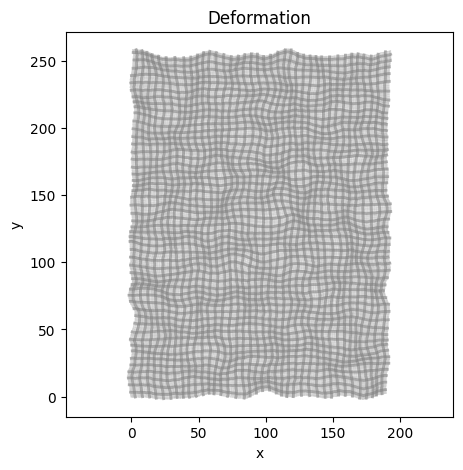

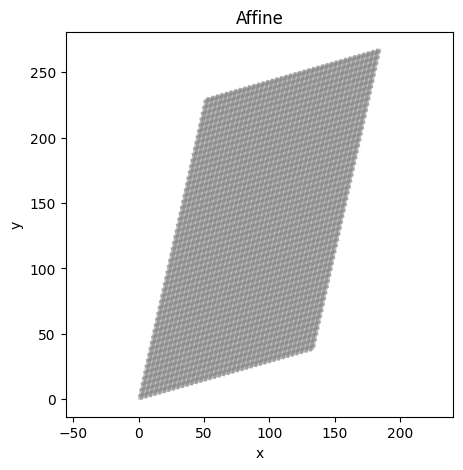

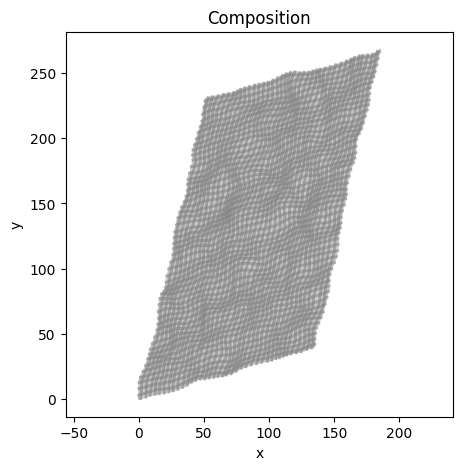

In [2]:
import torch
import matplotlib.pyplot as plt

import composable_mapping as cm
from torchvision.transforms import GaussianBlur



DIM0 = 192
DIM1 = 256

# coordinate_system = cm.CoordinateSystem.centered_normalized(spatial_shape=(256, 256))
coordinate_system = cm.CoordinateSystem.voxel((DIM0, DIM1)).multiply_world(
    torch.tensor([1, 1], dtype=torch.float32)
)
deformation = cm.samplable_volume(
    GaussianBlur(kernel_size=21, sigma=7.0)(20 * torch.randn(1, 2, DIM0, DIM1)),
    coordinate_system=coordinate_system,
    data_format=cm.DataFormat.voxel_displacements(),
)
affine = cm.affine(torch.tensor([[0.7, 0.2, 0.0], [0.2, 0.9, 0.0], [0.0, 0.0, 1.0]]))
composition = deformation @ affine
cm.visualize_as_deformed_grid(deformation)
plt.title("Deformation")
plt.show()
cm.visualize_to_as_deformed_grid(affine, target=coordinate_system)
plt.title("Affine")
plt.show()
cm.visualize_as_deformed_grid(composition)
plt.title("Composition")
plt.show()

In [38]:
# composable-mapping demo: multi-resolution dose + fine contour, 2D
# Requires: pip install composable-mapping torch matplotlib

import math
import torch
import numpy as np
import matplotlib.pyplot as plt

import composable_mapping as cm


# =========================
# Compatibility helpers
# =========================
def cs_grid(cs):
    """Return CoordinateSystem grid as a MappableTensor (handles property/method)."""
    g = getattr(cs, "grid")
    return g() if callable(g) else g

def cs_shape(cs):
    """Return (H, W[, ...]) regardless of property/method API."""
    s = getattr(cs, "spatial_shape")
    return s() if callable(s) else s

def cs_spacing(cs):
    """Return spacing tensor regardless of property/method API or CPU/GPU variant."""
    f = getattr(cs, "grid_spacing", None) or getattr(cs, "grid_spacing_cpu", None)
    if f is None:
        raise AttributeError("CoordinateSystem has no grid_spacing[ _cpu ] accessor")
    return f() if callable(f) else f

def mt_from_tensor(t, n_channel_dims=1):
    """Create a MappableTensor from a tensor, across versions."""
    if hasattr(cm, "mappable"):
        return cm.mappable(t, n_channel_dims=n_channel_dims)
    # Fallback: older/newer API name
    return cm.MappableTensor.from_tensor(t, n_channel_dims=n_channel_dims)

def get_sampler(name="linear"):
    """Version-safe access to samplers."""
    # Directly instantiate the interpolator classes
    return cm.NearestInterpolator() if name == "nearest" else cm.LinearInterpolator()


# =========================
# Coordinate systems & data
# =========================
def make_coordinate_systems(H=128, W=160, img_spacing_mm=1.0, dose_spacing_mm=0.5):
    """
    Two grids with identical physical FOV:
      - image grid: (H, W), spacing = img_spacing_mm
      - dose  grid: (Hd, Wd), spacing = dose_spacing_mm (denser grid)
    Origin = (0,0), orientation = identity (world in mm).
    """
    img_cs = cm.CoordinateSystem.voxel((H, W)).multiply_world(
        torch.tensor([img_spacing_mm, img_spacing_mm], dtype=torch.float32)
    )
    Hd = int(round(H * img_spacing_mm / dose_spacing_mm))
    Wd = int(round(W * img_spacing_mm / dose_spacing_mm))
    dose_cs = cm.CoordinateSystem.voxel((Hd, Wd)).multiply_world(
        torch.tensor([dose_spacing_mm, dose_spacing_mm], dtype=torch.float32)
    )

    # Optional FOV sanity check
    img_fov = torch.tensor([H * img_spacing_mm, W * img_spacing_mm])
    dose_fov = torch.tensor([Hd * dose_spacing_mm, Wd * dose_spacing_mm])
    if not torch.allclose(img_fov, dose_fov, atol=1e-3):
        print(f"[warn] FOV mismatch: img {img_fov.tolist()} mm vs dose {dose_fov.tolist()} mm")

    return img_cs, dose_cs

def make_synthetic_dose_smooth(dose_cs):
    """
    Create a smooth toy 'dose' on the dose grid (same physical FOV as image),
    using world-mm coordinates from the coordinate system.
    """
    gyx_mt = cs_grid(dose_cs)             # MappableTensor of world coords (y,x)
    gyx = gyx_mt.generate_values()        # Materialize -> Tensor
    # Expect shape [..., 2, H, W]
    if gyx.shape[-3] != 2:
        raise RuntimeError(f"Expected coord channels=2 at dim -3, got shape {gyx.shape}")
    y = gyx[..., 0, :, :]
    x = gyx[..., 1, :, :]

    H, W = y.shape[-2:]
    sy, sx = cs_spacing(dose_cs)
    cy, cx = (sy * H) / 2.0, (sx * W) / 2.0

    g1 = torch.exp(-((y - cy) ** 2 + (x - cx) ** 2) / (2.0 * 15.0 ** 2))
    g2 = 0.6 * torch.exp(-((y - 0.35 * 2 * cy) ** 2 + (x - 0.65 * 2 * cx) ** 2) / (2.0 * 10.0 ** 2))
    dose = (g1 + g2).unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
    return dose.contiguous()

def make_synthetic_dose(dose_cs):
    """
    Create a smooth toy 'dose' on the dose grid (same physical FOV as image),
    using world-mm coordinates from the coordinate system.
    Now has three centers, with the third having a sharp dose gradient.
    """
    gyx_mt = cs_grid(dose_cs)             # MappableTensor of world coords (y,x)
    gyx = gyx_mt.generate_values()        # Materialize -> Tensor
    # Expect shape [..., 2, H, W]
    if gyx.shape[-3] != 2:
        raise RuntimeError(f"Expected coord channels=2 at dim -3, got shape {gyx.shape}")
    y = gyx[..., 0, :, :]
    x = gyx[..., 1, :, :]

    H, W = y.shape[-2:]
    sy, sx = cs_spacing(dose_cs)
    cy, cx = (sy * H) / 2.0, (sx * W) / 2.0

    # Broad central Gaussian
    g1 = torch.exp(-((y - cy) ** 2 + (x - cx) ** 2) / (2.0 * 15.0 ** 2))

    # Second, slightly smaller Gaussian off-center
    g2 = 0.6 * torch.exp(
        -((y - 0.35 * 2 * cy) ** 2 + (x - 0.65 * 2 * cx) ** 2) / (2.0 * 10.0 ** 2)
    )

    # Third Gaussian with sharp dose gradient (small sigma)
    sharp_sigma = 3.0  # mm; smaller -> steeper gradient
    sharp_cy = 0.2 * 2 * cy
    sharp_cx = 0.25 * 2 * cx
    g3 = 0.8 * torch.exp(
        -((y - sharp_cy) ** 2 + (x - sharp_cx) ** 2) / (2.0 * sharp_sigma ** 2)
    )

    dose = (g1 + g2 + g3).unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
    return dose.contiguous()


def make_circle_contour(center_yx_mm, radius_mm, step_mm=0.1):
    """
    Return Nx2 world coordinates (in mm) for a circle with arc-length spacing ~step_mm.
    center_yx_mm: (y, x) in mm
    """
    circumference = 2.0 * math.pi * radius_mm
    n = max(16, int(round(circumference / step_mm)))
    # Older torch doesn't support endpoint=. Emulate [0, 2π) by dropping last point.
    thetas = torch.linspace(0.0, 2.0 * math.pi, n + 1, dtype=torch.float32)[:-1]
    y = center_yx_mm[0] + radius_mm * torch.sin(thetas)
    x = center_yx_mm[1] + radius_mm * torch.cos(thetas)
    return torch.stack([y, x], dim=-1)  # [N, 2] world coords in mm

In [9]:
print(dose.shape)

torch.Size([1, 1, 1, 384, 512])


In [39]:

### coordinate system
img_cs, dose_cs = make_coordinate_systems(DIM0, DIM1, img_spacing_mm=1.0, dose_spacing_mm=0.5)

# Synthetic high-res dose on its own grid (0.5 mm)
dose = make_synthetic_dose(dose_cs)  # [1,1,Hd,Wd]

dose_image_fullres = cm.samplable_volume(
    dose[0,...],
    coordinate_system=dose_cs,
)

# dose_image_halfres = cm.samplable_volume(
#     dose[0,...],
#     coordinate_system=img_cs,
# )
# ValueError: Coordinate system spatial shape must match the data spatial shape. Coordinate system spatial shape: (192, 256), data spatial shape: (384, 512).
dose_image_halfres = dose_image_fullres.resample_to(img_cs)



deformed_dose_image_fullres = dose_image_fullres @ composition
deformed_dose_image_halfres = dose_image_halfres @ composition

deformed_dose_image_halfres_resampled = deformed_dose_image_halfres.resample_to(dose_cs)

In [29]:
print(dose_image_fullres.sample().displacements)

tensor([[[[1.9655e-25, 2.6107e-25, 3.4639e-25,  ..., 4.6040e-25,
           3.4724e-25, 2.6161e-25],
          [2.4315e-25, 3.2297e-25, 4.2853e-25,  ..., 5.6978e-25,
           4.2971e-25, 3.2373e-25],
          [3.0047e-25, 3.9911e-25, 5.2955e-25,  ..., 7.0438e-25,
           5.3119e-25, 4.0017e-25],
          ...,
          [3.7089e-25, 4.9265e-25, 6.5365e-25,  ..., 8.6631e-25,
           6.5365e-25, 4.9265e-25],
          [3.0047e-25, 3.9911e-25, 5.2955e-25,  ..., 7.0183e-25,
           5.2955e-25, 3.9911e-25],
          [2.4315e-25, 3.2297e-25, 4.2853e-25,  ..., 5.6794e-25,
           4.2853e-25, 3.2297e-25]]]])


torch.Size([1, 1, 384, 512])


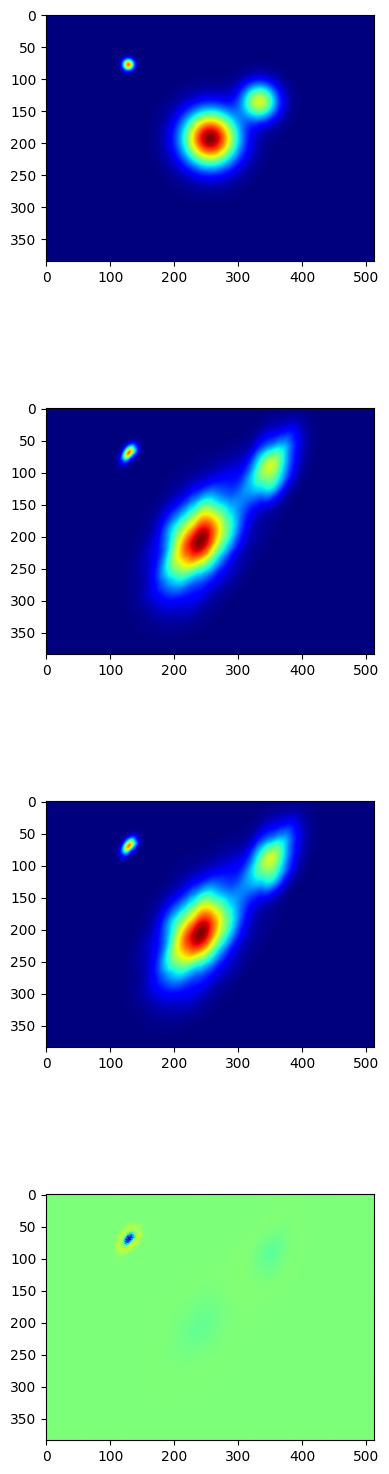

In [44]:
diff = deformed_dose_image_fullres.sample() - deformed_dose_image_halfres_resampled.sample()
print(diff.shape)

# plt.figure(figsize=(4,12))
# plt.subplot(3,1,1)
# plt.imshow(dose_image_fullres.sample().displacements.numpy().squeeze(), cmap='jet')
# plt.subplot(3,1,2)
# plt.imshow(deformed_dose_image_fullres.sample().displacements.numpy().squeeze(), cmap='jet')
# plt.subplot(3,1,3)
# plt.imshow(deformed_dose_image_halfres_resampled.sample().displacements.numpy().squeeze(), cmap='jet')

plt.figure(figsize=(4,16))
ax1 = plt.subplot(4,1,1)
im1 = plt.imshow(
    dose_image_fullres.sample().displacements.numpy().squeeze(),
    cmap='jet', vmin=0, vmax=1
)

ax2 = plt.subplot(4,1,2)
im2 = plt.imshow(
    deformed_dose_image_fullres.sample().displacements.numpy().squeeze(),
    cmap='jet', vmin=0, vmax=1
)

ax3 = plt.subplot(4,1,3)
im3 = plt.imshow(
    deformed_dose_image_halfres_resampled.sample().displacements.numpy().squeeze(),
    cmap='jet', vmin=0, vmax=1
)


ax4 = plt.subplot(4,1,4)
diff = deformed_dose_image_halfres_resampled.sample().displacements.numpy().squeeze() - deformed_dose_image_fullres.sample().displacements.numpy().squeeze()
im4 = plt.imshow(
    diff,
    cmap='jet', vmin=-0.01, vmax=0.01
)

# one shared colorbar for all three subplots
# cbar = plt.colorbar(im1, ax=[ax1])
cbar.set_label('Displacement (normalized)')

plt.tight_layout()
plt.show()


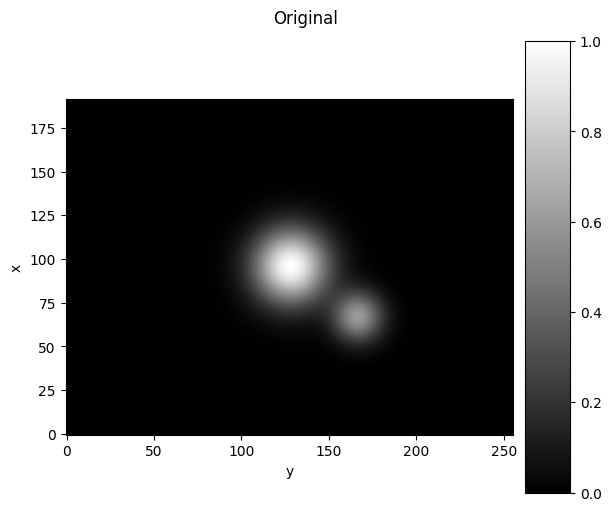

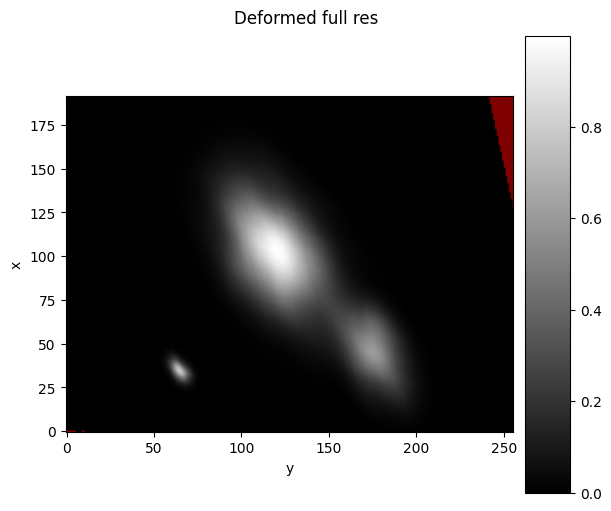

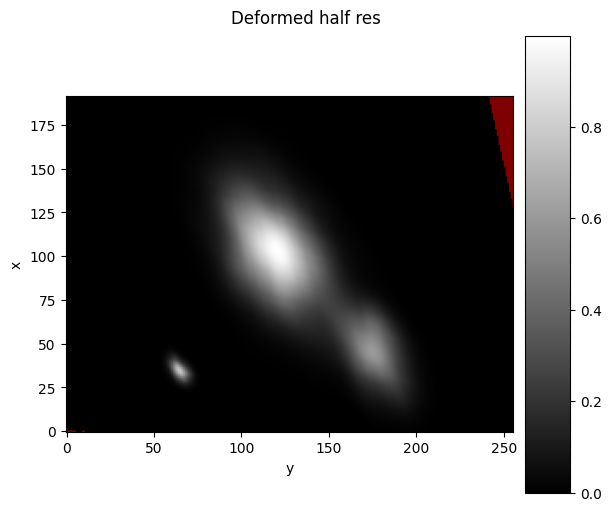

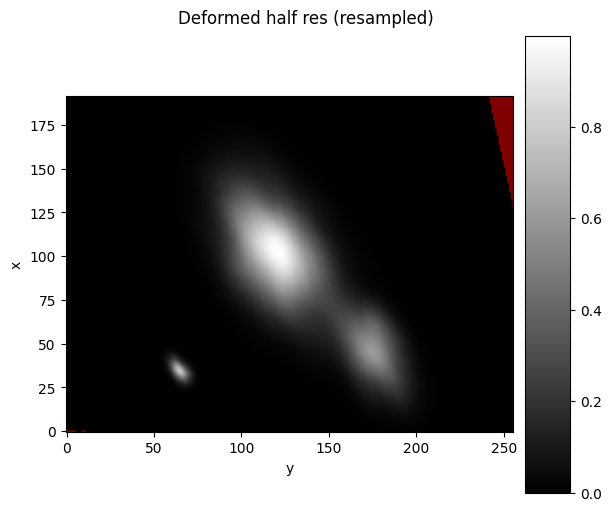

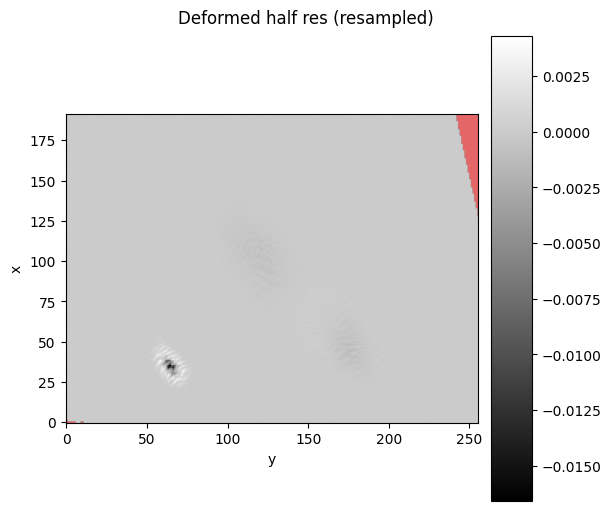

In [41]:
# We flip the coordinates for visualization for the image to show correct size up
visualization_coordinates = coordinate_system.transform_world_with_diagonal_matrix(
    torch.tensor([-1.0, 1.0])
)
fig = cm.visualize_to_as_image(dose_image, target=coordinate_system)
fig.suptitle("Original")
plt.show()
fig = cm.visualize_to_as_image(deformed_dose_image_fullres, target=coordinate_system)
fig.suptitle("Deformed full res")
plt.show()
fig = cm.visualize_to_as_image(deformed_dose_image_halfres, target=coordinate_system)
fig.suptitle("Deformed half res")
plt.show()

fig = cm.visualize_to_as_image(deformed_dose_image_halfres_resampled, target=coordinate_system)
fig.suptitle("Deformed half res (resampled)")
plt.show()
fig = cm.visualize_to_as_image(deformed_dose_image_halfres_resampled-deformed_dose_image_fullres, target=coordinate_system)
fig.suptitle("Deformed half res (resampled)")
plt.show()

In [18]:
deformed_dose_image_halfres_resampled

SamplableVolume(data=MappableTensor(displacements=tensor([[[[1.9655e-25, 2.2319e-25, 2.8768e-25,  ..., 3.1144e-10,
           2.3044e-10, 1.6643e-10],
          [2.1438e-25, 2.5011e-25, 3.1621e-25,  ..., 2.9255e-10,
           2.2276e-10, 1.5524e-10],
          [2.4741e-25, 3.0037e-25, 3.8136e-25,  ..., 2.8230e-10,
           2.1291e-10, 1.5189e-10],
          ...,
          [1.0812e-09, 1.2344e-09, 1.4481e-09,  ..., 6.5199e-24,
           6.1612e-24, 5.9155e-24],
          [1.0703e-09, 1.2217e-09, 1.4387e-09,  ..., 5.5490e-24,
           5.3047e-24, 5.0604e-24],
          [1.0518e-09, 1.1892e-09, 1.3666e-09,  ..., 4.6938e-24,
           4.4271e-24, 4.1379e-24]]]]), mask=tensor([[[[False, False, False,  ...,  True,  True,  True],
          [False,  True,  True,  ...,  True,  True,  True],
          [False,  True,  True,  ...,  True,  True,  True],
          ...,
          [ True,  True,  True,  ..., False, False, False],
          [ True,  True,  True,  ..., False, False, False],
     